In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
from glob import glob
from const import ID2LABELS_SMG as ID2LABELS
import ast


In [2]:
os.environ['OMP_NUM_THREADS']='1'

In [3]:
experiment_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg'
run_name = 'videomae_vit_base_patch16_224_kinetic_400_densepose_dual_multi'
data_folder = r'D:\Project-mpg microgesture\human_micro_gesture_classifier\scripts\miga_smg\overfit_videomae_vit_base_patch16_224_kinetic_400_densepose_dual\outputs\extracted_features'



In [4]:
# load features
all_file_paths = glob(osp.join(data_folder, '*.npy'))
all_data_list = []
for p in all_file_paths:
    all_data_list.append(np.load(p))
concatenated_array = np.stack(all_data_list, axis=0)

In [5]:
concatenated_array.shape

(4904, 770)

In [6]:
file_ids = [float(osp.basename(f).split('.')[0].split('_ ')[1]) for f in all_file_paths]
file_ids = np.array(file_ids).reshape(-1,1)
concatenated_array = np.concatenate((concatenated_array,file_ids), axis=1)

In [7]:
# Reshape the concatenated array to shape (N/2, d, 2)
even_inds = np.expand_dims(concatenated_array[::2,: ], axis=2)
odd_inds = np.expand_dims(concatenated_array[1::2,: ], axis=2)
reshaped_array = np.concatenate((even_inds, odd_inds), axis=2).mean(axis=2, keepdims=False)

In [8]:
X = reshaped_array[:, :-3]
y = even_inds[:,-3].astype(int)
# y = [str(a[0]) for a in y]
inds = even_inds[:,-2].astype(int)
# y

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = StandardScaler().fit_transform(X)

from umap import UMAP
reducer1 = UMAP(n_components=15,    n_neighbors=5)
reducer2 = UMAP(n_components=2, n_neighbors=5)


# reducer1 = PCA(n_components=15)
# reducer2 = UMAP(n_components=2)

In [10]:
# X_reduced = reducer1.fit_transform(X, y=y)
# embedding = reducer2.fit_transform(X_reduced, y=y)
embedding = reducer2.fit_transform(X, y=y)

# X_reduced = reducer1.fit_transform(X)
# embedding = reducer2.fit_transform(X_reduced, y=y)

In [11]:
from sklearn.random_projection import SparseRandomProjection
from sklearn.decomposition import PCA
# recuder = PCA(n_components=15)
# X_reduced = recuder.fit_transform(X)

In [12]:
# X_reduced.shape

In [13]:
from imblearn.under_sampling   import AllKNN, RepeatedEditedNearestNeighbours, EditedNearestNeighbours, NearMiss, TomekLinks,CondensedNearestNeighbour, NeighbourhoodCleaningRule, InstanceHardnessThreshold

from imblearn.combine import SMOTEENN

In [20]:
# resampler = TomekLinks(sampling_strategy='all')
# resampler = NearMiss()
# resampler = CondensedNearestNeighbour()
# resampler = NeighbourhoodCleaningRule()
resampler = InstanceHardnessThreshold()
# resampler =  AllKNN()
# resampler = RepeatedEditedNearestNeighbours()

# resampler = SMOTEENN()

X_rus, y_rus = resampler.fit_resample(X, y)
y_rus.shape

(204,)

In [21]:
sample_inds = resampler.sample_indices_

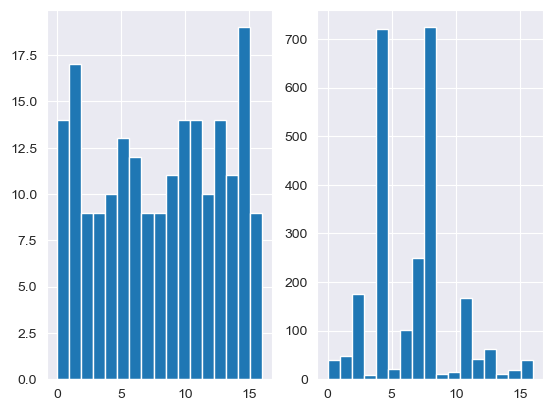

In [22]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].hist(y_rus, bins=17)
axes[1].hist(y, bins=17)
plt.show()

In [18]:
# y[sample_inds]

In [23]:
from collections import Counter
before = Counter([a[0] for a in y])
after = Counter([a for a in y_rus])
counts = {'before': before, 'after': after}
df_counters = pd.DataFrame.from_dict(counts)
df_counters.sort_index(inplace=True)
df_counters = df_counters.reset_index()
df_counters['label'] = df_counters['index'].apply(lambda x: ID2LABELS[x+1])
df_counters

,index,before,after,label
0,0,40,14,Turtling neck and shoulder
1,1,48,17,Rubbing eyes and forehead
2,2,175,9,Folding arms
3,3,9,9,Touching or covering suprasternal notch
4,4,720,10,Moving legs
5,5,21,13,Touching or scratching neck
6,6,101,12,Folding arms behind body
7,7,249,9,Rubbing hands and crossing finger
8,8,724,9,Arms akimbo
9,9,11,11,Crossing legs


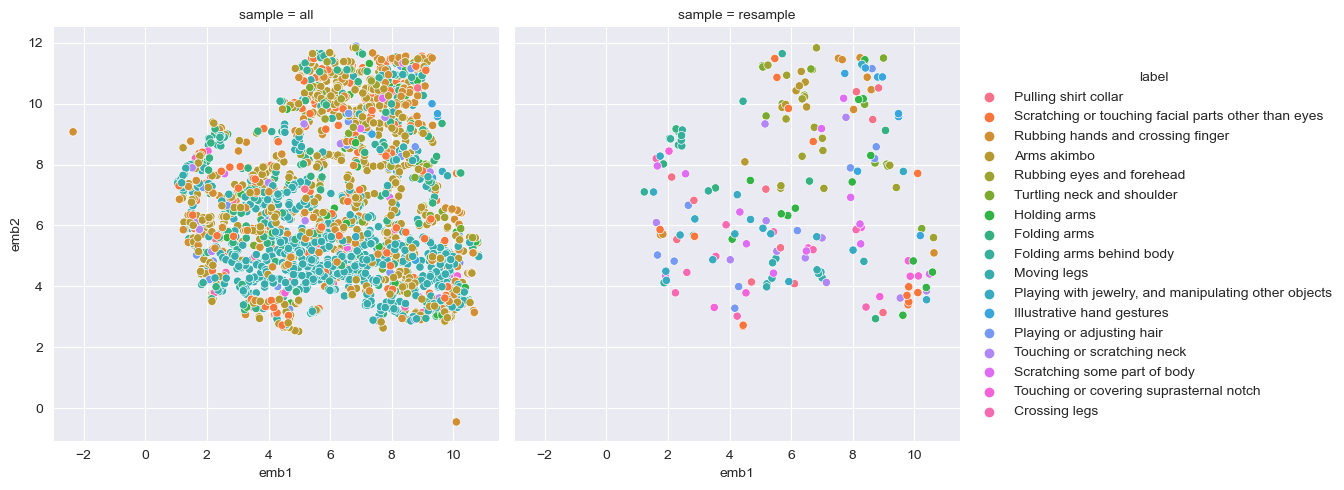

In [24]:
df = pd.DataFrame(zip(embedding[:,0], embedding[:, 1], y), columns=['emb1', 'emb2', 'label'])
df['label'] = df['label'].apply(lambda x: ID2LABELS[x[0]+1])
df['sample'] = 'all'
df_sub = df.iloc[sample_inds,:].copy()
df_sub['sample'] = 'resample'
df_all = pd.concat([df, df_sub], axis=0)
sns.relplot(
    data=df_all, x="emb1", y="emb2",
    col="sample", hue="label",
    kind="scatter"
)

In [21]:
reducer3 = UMAP(n_components=2 )
embedding_2 = reducer3.fit_transform(X_rus, y_rus)

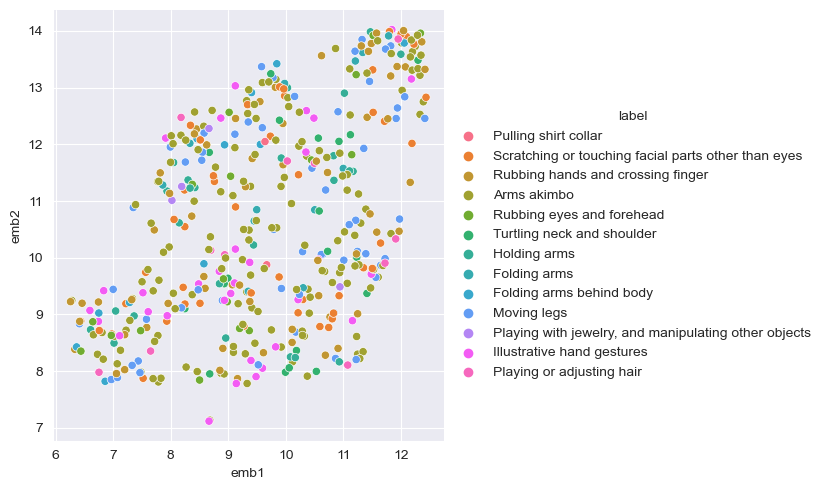

In [22]:
df = pd.DataFrame(zip(embedding_2[:,0], embedding_2[:, 1], y), columns=['emb1', 'emb2', 'label'])
df['label'] = df['label'].apply(lambda x: ID2LABELS[x[0]+1])
df['sample'] = 'all'
# df_sub = df.iloc[sample_inds,:].copy()
# df_sub['sample'] = 'resample'
df_all = pd.concat([df], axis=0)
sns.relplot(
    data=df_all, x="emb1", y="emb2",
    hue="label",
    kind="scatter"
)

In [25]:
# resample train data

train_data_path = osp.join(experiment_folder, run_name,'dataset','train_full.csv')
df_train_orig = pd.read_csv(train_data_path)

In [26]:
df_train_new = df_train_orig.iloc[sample_inds,:]
labels = df_train_new['labels'].apply(lambda x: np.argmax(ast.literal_eval(x)))

In [27]:
save_train_data_path = osp.join(experiment_folder, run_name,'dataset','train_InstanceHardnessThreshold.csv')
df_train_new.to_csv(save_train_data_path)

In [28]:
len(df_train_new['labels'].values[0].split(','))

17

In [29]:
labels.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

In [30]:
# recalculate weights, use sklearn
from sklearn.utils.class_weight import compute_class_weight

classes = labels.unique()
class_weights_vals = compute_class_weight(class_weight="balanced", classes=classes, y=labels)
# compute_class_weight()
class_weights = pd.DataFrame(zip(classes, class_weights_vals), columns=['class', 'positive_weights'])
class_weights.sort_values(by='class', inplace=True)
class_weights



,class,positive_weights
0,0,0.857143
1,1,0.705882
2,2,1.333333
3,3,1.333333
4,4,1.200000
5,5,0.923077
6,6,1.000000
7,7,1.333333
8,8,1.333333
9,9,1.090909


In [31]:
before = Counter([a[0] for a in y])
after = Counter([a for a in y_rus])
new = Counter(labels)
counts = {'before': before, 'after': after, 'new':new, 'weights': {a:b for a,b in zip(classes, class_weights_vals)}}
df_counters = pd.DataFrame.from_dict(counts)
df_counters.sort_index(inplace=True)
df_counters = df_counters.reset_index()
df_counters['label'] = df_counters['index'].apply(lambda x: ID2LABELS[x+1])
df_counters

,index,before,after,new,weights,label
0,0,40,14,14,0.857143,Turtling neck and shoulder
1,1,48,17,17,0.705882,Rubbing eyes and forehead
2,2,175,9,9,1.333333,Folding arms
3,3,9,9,9,1.333333,Touching or covering suprasternal notch
4,4,720,10,10,1.200000,Moving legs
5,5,21,13,13,0.923077,Touching or scratching neck
6,6,101,12,12,1.000000,Folding arms behind body
7,7,249,9,9,1.333333,Rubbing hands and crossing finger
8,8,724,9,9,1.333333,Arms akimbo
9,9,11,11,11,1.090909,Crossing legs


In [32]:
save_folder = osp.join(experiment_folder, run_name,'dataset')
class_weights.to_csv(osp.join(save_folder, 'weights_InstanceHardnessThreshold.csv'))
import json
wrapped_data = {'data': class_weights.to_dict(orient='records')}

# Save wrapped data as JSON
with open(osp.join(save_folder, 'weights_InstanceHardnessThreshold.json'), 'w') as json_file:
    json.dump(wrapped_data, json_file, indent=4)